<a href="https://colab.research.google.com/github/BassamTar99/StockPrediction/blob/News_Impact_Model/NEWS_Model_490.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install yfinance matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [26]:
ticker = input('Enter the stock ticker (e.g. AAPL): ').upper()
lookback_days = 3650  # days of history to fetch
end_date = datetime.today()
start_date = end_date - timedelta(days=lookback_days)
def_features = ['Open', 'High', 'Low', 'Close', 'Volume']
df = yf.download(ticker, start=start_date, end=end_date)[def_features]


Enter the stock ticker (e.g. AAPL): AAPL


[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-04-23,28.652941,29.126394,28.617207,28.958899,183083600
2015-04-24,29.142029,29.173295,28.860634,29.095129,178103600
2015-04-27,29.548484,29.731614,29.289423,29.624414,387816800
2015-04-28,30.028641,30.046505,28.936569,29.157661,475696000
2015-04-29,29.068333,29.387690,28.652944,28.728874,253544400


In [27]:
sma_windows = [10, 20, 50]
for w in sma_windows:
    df[f'SMA_{w}'] = df['Close'].rolling(window=w).mean()
rsi_window = 14
diff = df['Close'].diff()
gain = diff.clip(lower=0)
loss = -diff.clip(upper=0)
avg_gain = gain.rolling(window=rsi_window).mean()
avg_loss = loss.rolling(window=rsi_window).mean()
rs = avg_gain / avg_loss
rs = rs.replace([np.inf, -np.inf], np.nan).fillna(0)
df['RSI'] = 100 - (100 / (1 + rs))
macd_fast, macd_slow, macd_signal = 12, 26, 9
ema_fast = df['Close'].ewm(span=macd_fast, adjust=False).mean()
ema_slow = df['Close'].ewm(span=macd_slow, adjust=False).mean()
df['MACD'] = ema_fast - ema_slow
df['MACD_SIGNAL'] = df['MACD'].ewm(span=macd_signal, adjust=False).mean()
df.dropna(inplace=True)

In [ ]:
df.tail()

Price,Open,High,Low,Close,Volume,SMA_10,SMA_20,SMA_50,RSI,MACD,MACD_SIGNAL
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2025-04-11,186.100006,199.539993,186.059998,198.149994,87435900,200.208002,209.207001,224.458866,40.058122,-9.884171,-8.173183
2025-04-14,211.440002,212.940002,201.160004,202.520004,101352900,198.247002,208.633002,223.794450,40.762342,-8.986913,-8.335929
2025-04-15,201.860001,203.509995,199.800003,202.139999,51343900,196.142001,208.105502,223.282058,41.425670,-8.211832,-8.311109
2025-04-16,198.360001,200.699997,192.369995,194.270004,59732400,193.180002,207.057001,222.516572,37.531617,-8.138799,-8.276647
2025-04-17,197.199997,198.830002,194.419998,196.979996,51334300,192.559001,206.201001,221.811878,40.934306,-7.772647,-8.175847


In [28]:
feature_cols = def_features + [f'SMA_{w}' for w in sma_windows] + ['RSI', 'MACD', 'MACD_SIGNAL']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[feature_cols])
timesteps = 30  # sequence length for model

def create_sequences(data, timesteps, target_idx):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps, target_idx])
    return np.array(X), np.array(y)

target_idx = feature_cols.index('Close')
X, y = create_sequences(scaled_data, timesteps, target_idx)

In [8]:
split_frac = 0.8
split_idx = int(len(X) * split_frac)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [ ]:
hidden_units = 50
num_layers = 2
dropout_rate = 0.2

def build_model(input_shape):
    model = Sequential()
    for i in range(num_layers):
        return_seq = i < num_layers - 1
        if i == 0:
            model.add(
                LSTM(
                    hidden_units,
                    return_sequences=return_seq,
                    input_shape=input_shape,
                )
            )
        else:
            model.add(LSTM(hidden_units, return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_model((timesteps, X.shape[2]))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 50)         │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,651 (127.54 KB)

 Trainable params: 32,651 (127.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 32
epochs = 50
val_split = 0.1
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0124 - val_loss: 8.5359e-04 - learning_rate: 0.0010
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0014 - val_loss: 7.8972e-04 - learning_rate: 0.0010
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0013 - val_loss: 8.9741e-04 - learning_rate: 0.0010
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0010 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0010 - val_loss: 6.1767e-04 - learning_rate: 5.0000e-04
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 8.1145e-04 - val_loss: 4.4179e-04 - learning_rate: 5.0000e-04
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 9.2807e-04 - val_loss: 0.0018 - learning_rate: 5.0000e-04
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.8491e-04 - val_loss: 4.6703e-04 - learning_rate: 5.0000e-04
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.9804e-04 - val_

In [ ]:
y_pred = model.predict(X_test)
zeros = np.zeros((len(y_test), len(feature_cols) - 1))
y_true_unscaled = scaler.inverse_transform(
    np.hstack((zeros, y_test.reshape(-1, 1)))
)[:, -1]
y_pred_unscaled = scaler.inverse_transform(
    np.hstack((zeros, y_pred))
)[:, -1]
rmse = np.sqrt(mean_squared_error(y_true_unscaled, y_pred_unscaled))
print(f"Test RMSE for {ticker}: {rmse:.2f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test RMSE for AAPL: 0.99


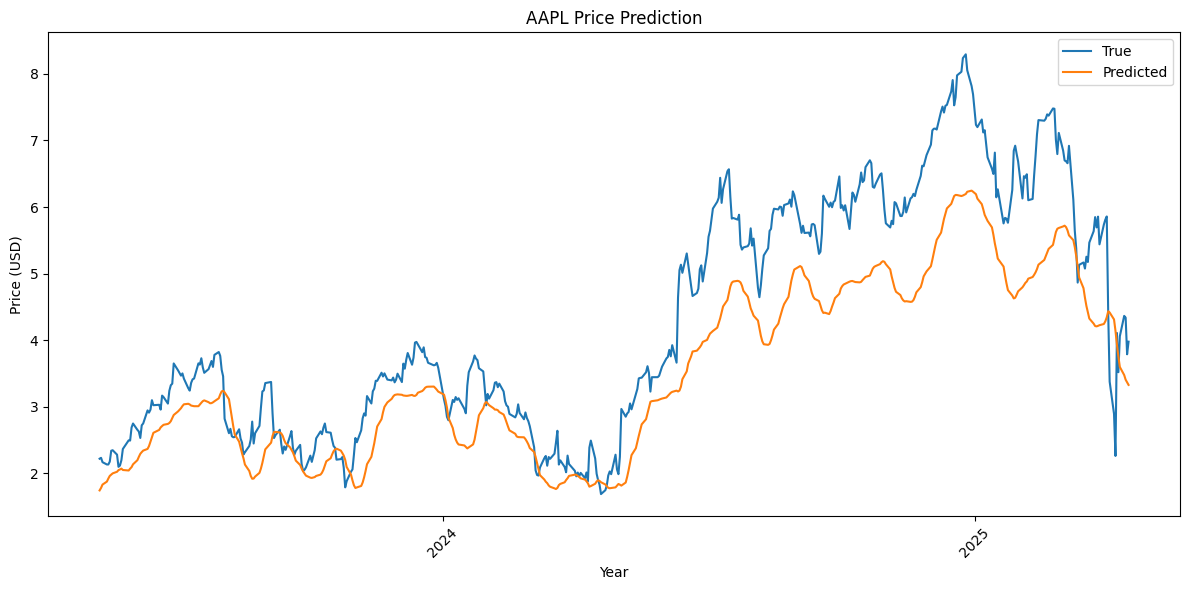

In [ ]:
import matplotlib.dates as mdates

test_dates = df.index[timesteps + split_idx :]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_true_unscaled, label='True')
plt.plot(test_dates, y_pred_unscaled, label='Predicted')
plt.title(f"{ticker} Price Prediction")
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
!pip install newsapi-python nltk

from newsapi import NewsApiClient
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from datetime import timedelta

# download VADER lexicon
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [29]:
api_key = input("Enter your NewsAPI.org API key: ").strip()
company_name = input("Enter the company name (e.g. Apple Inc): ").strip()

newsapi = NewsApiClient(api_key=api_key)
analyzer = SentimentIntensityAnalyzer()


Enter your NewsAPI.org API key: 996b1e5a4c2146a1818ec3a8056facf5
Enter the company name (e.g. Apple Inc): Apple Inc


In [43]:
# Cell 10 — Fetch Articles (respecting NewsAPI free‑plan date limit + 7‑day look‑back)
from datetime import timedelta, datetime
from newsapi.newsapi_client import NewsAPIException

# NewsAPI free plan earliest allowed date
plan_limit = datetime(2025, 3, 22)

# 1) Compute raw 7‑day look‑back start
raw_start = df.index.min() - timedelta(days=7)

# 2) Clamp to plan limit
start_date = max(raw_start, plan_limit)
start = start_date.strftime('%Y-%m-%d')
end   = df.index.max().strftime('%Y-%m-%d')

print(f"Fetching news from {start} through {end}…")

# 3) Fetch loop (100‑article cap, 50/page)
all_articles = []
page        = 1
max_results = 100
page_size   = 50
fetched     = 0

while True:
    try:
        res = newsapi.get_everything(
            q=company_name,
            from_param=start,
            to=end,
            language='en',
            sort_by='publishedAt',
            page=page,
            page_size=page_size
        )
    except NewsAPIException as e:
        print("Reached NewsAPI limit, stopping fetch:", e)
        break

    articles = res.get('articles', [])
    if not articles:
        break

    all_articles.extend(articles)
    fetched += len(articles)
    print(f"  → Fetched {fetched} articles so far")

    if fetched >= max_results:
        break
    page += 1

print(f"Total articles fetched: {len(all_articles)}")


Fetching news from 2025-03-22 through 2025-04-21…
Reached NewsAPI limit, stopping fetch: {'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
Total articles fetched: 0


In [39]:
# Cell N+4 — Sentiment Scoring & Date Extraction
rows = []
for art in all_articles:
    ts = pd.to_datetime(art['publishedAt']).tz_convert(None).date()
    text = (art['title'] or '') + ' ' + (art['description'] or '')
    score = analyzer.polarity_scores(text)['compound']
    rows.append({'date': ts, 'sentiment': score})

sent_df = pd.DataFrame(rows)


,news_sentiment
date,
2025-04-17,0
2025-04-18,0
2025-04-19,0
2025-04-20,0
2025-04-21,0


In [42]:
# Cell 12 — Merge News Sentiment with 7‑day backward‑fill (UPDATED)

import pandas as pd

# 1) Copy price data & flatten columns if needed
price_df = df.copy()
if hasattr(price_df.columns, 'nlevels') and price_df.columns.nlevels > 1:
    price_df.columns = price_df.columns.get_level_values(0)

# 2) Reset the index to turn the DatetimeIndex into a column
price_df = price_df.reset_index()

# 3) Rename that first column to 'date' (handles unnamed or differently named index)
price_df.columns.values[0] = 'date'

# 4) Ensure 'date' is datetime
price_df['date'] = pd.to_datetime(price_df['date'])

# 5) Prepare daily_sent_df (group & average)
daily_sent_df = (
    sent_df
      .groupby('date')['sentiment']
      .mean()
      .reset_index(name='news_sentiment')
)
daily_sent_df['date'] = pd.to_datetime(daily_sent_df['date'])

# 6) Merge on 'date'
price_df = price_df.merge(daily_sent_df, on='date', how='left')

# 7) Backward‑fill each sentiment up to 7 days, then fill remaining NaNs with 0
price_df['news_sentiment'] = (
    price_df['news_sentiment']
      .fillna(method='bfill', limit=7)
      .fillna(0)
)

# 8) Restore datetime index
price_df.set_index('date', inplace=True)

# 9) Inspect the tail
price_df.tail(20)


<ipython-input-42-1481e4f6ba7e>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill', limit=7)


,Open,High,Low,Close,Volume,SMA_10,SMA_20,SMA_50,RSI,MACD,MACD_SIGNAL,news_sentiment
date,,,,,,,,,,,,
2025-03-24,221.000000,221.479996,218.580002,220.729996,44299500,215.602000,226.707000,231.377927,34.702099,-5.884257,-5.276226,0.000000
2025-03-25,220.770004,224.100006,220.080002,223.750000,34493600,215.893001,225.542500,231.121130,38.583127,-5.154985,-5.251978,0.000000
2025-03-26,223.509995,225.020004,220.470001,221.529999,34466100,216.348001,224.601000,230.868878,37.297499,-4.701965,-5.141975,0.000000
2025-03-27,221.389999,224.990005,220.559998,223.850006,37094800,217.765002,223.928500,230.685403,35.614372,-4.108380,-4.935256,0.000000
2025-03-28,221.669998,223.809998,217.679993,217.899994,39818600,218.206001,222.731500,230.291228,39.864582,-4.071147,-4.762434,0.000000
2025-03-31,217.009995,225.619995,216.229996,222.130005,65299300,219.019002,221.936501,230.173642,51.438135,-3.658143,-4.541576,0.000000
2025-04-01,219.809998,223.679993,218.899994,223.190002,36412700,220.069002,221.299501,230.042893,57.384069,-3.208319,-4.274925,0.000000
2025-04-02,221.320007,225.190002,221.020004,223.889999,35905900,220.934001,220.707001,230.072784,70.042307,-2.763490,-3.972638,0.000000
2025-04-03,205.539993,207.490005,201.250000,203.190002,103419000,219.843001,219.100001,229.664901,40.160488,-4.034766,-3.985063,0.000000
